# Detect edges

In [2]:
import numpy as np
import pandas as pd
import scipy as sp

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.colors import ListedColormap

import seaborn as sns
sns.set_style('whitegrid')

import time

import matplotlib 
from matplotlib.colors import Normalize
from scipy.stats import multivariate_normal as norm, multinomial, uniform

%run сell_boundaries.py

## Data load

In [3]:
df_spatial = pd.read_csv('spatial.csv', index_col=0)
df_spatial['Gene'] = df_spatial['Gene'] - 1
df_spatial.head(5)

,Gene,x,y
1,0,8400,44522
2,0,7503,42213
3,0,7253,43802
4,0,8611,40784
5,0,5318,41871


In [4]:
df_spatial_c = pd.read_csv('spatial_centers.csv', index_col=0)
df_spatial_c.head(5)

,x,y
1,5686,45000
2,5157,44998
3,7030,44998
4,7137,44998
5,9767,44996


## Data preparing for EM algorithm 

In [8]:
x_mean = df_spatial.x.mean() + 200
y_mean = df_spatial.y.mean() + 200
std = 1500
df_spatial_subset = df_spatial.loc[(df_spatial.x >= x_mean - std) & (df_spatial.x <= x_mean + std) & 
                    (df_spatial.y >= y_mean - std) & (df_spatial.y <= y_mean + std)].copy().reset_index(drop=True)
gene_order = dict(zip(df_spatial_subset.Gene.unique(), np.argsort(df_spatial_subset.Gene.unique())))
df_spatial_subset.Gene = df_spatial_subset.Gene.map(gene_order)

In [9]:
unique_gene = df_spatial.Gene.unique()

cmap = matplotlib.cm.get_cmap('Dark2')
normalizer = matplotlib.colors.Normalize(vmin=unique_gene.min(), vmax=unique_gene.max())
df_spatial_subset['Cmap'] = list(map(tuple, cmap(normalizer(df_spatial_subset.Gene.values))))

## EM for multinominal distribution

In [10]:
x_classes = np.array([to_categorial(n, df_spatial_subset.Gene.max() + 1) for n in df_spatial_subset.Gene])
assert np.all(x_classes.sum(axis=0).astype(int) != 0)

## EM for normal distribution with noise

In [11]:
xy = df_spatial_subset[['x', 'y']].copy()

centers = df_spatial_c.loc[(df_spatial_c.x >= x_mean - std) & (df_spatial_c.x <= x_mean + std) & 
                    (df_spatial_c.y >= y_mean - std) & (df_spatial_c.y <= y_mean + std)].values

centers.shape[0]

354

In [12]:
xy['Class'] = list(x_classes)
obs_data = xy.copy()

common_densities = [norm_density] * (centers.shape[0] - 1) + [noise_density] 
common_maximizers = [norm_maximize] * (centers.shape[0] - 1) + [noise_maximize]

common_params = []
for c in centers:
    prob = np.random.uniform(low=1, high=100, size=x_classes.shape[1] + 1)
    common_params.append({'w' : 1./(centers.shape[0] + 1), 
                          'mean' : c, 
                          'cov_matrix' : np.diag(np.random.uniform(size=2, low=40000, high=80000)), 
                          'prob' : prob/prob.sum()})

common_pred, common_params = EM(obs_data, common_params, common_densities, common_maximizers, 
                                max_iters=100, 
                                iters_del=10, 
                                eps=1e-2)

EM fit started
EM part done for 46 s in 10 iterations. Norm 3.78893289219637
EM part done for 97 s in 20 iterations. Norm 2.834786004769879
EM part done for 153 s in 30 iterations. Norm 2.5071754886056583
EM part done for 213 s in 40 iterations. Norm 2.177415333385147
EM part done for 262 s in 50 iterations. Norm 1.595621758911586
EM part done for 311 s in 60 iterations. Norm 1.3086964272097923
EM part done for 367 s in 70 iterations. Norm 1.1693203290697545
EM part done for 419 s in 80 iterations. Norm 1.1334239138720368
EM part done for 478 s in 90 iterations. Norm 1.5392164239832122
EM part done for 533 s in 100 iterations. Norm 1.4020690012210943
EM part done for 533 s in 100 iterations. Norm 1.4020690012210943


### Visualization for normal distribution

In [15]:
df_spatial_subset['Class'] = common_pred

In [16]:
c_coef = 1.35

cluster_centers = df_spatial_subset[['x', 'y', 'Class']].groupby('Class').apply(np.mean).drop('Class', axis=1)
cluster_centers.columns = ['MeanX', 'MeanY']

cluster_shape = df_spatial_subset[['x', 'y', 'Class']].groupby('Class').apply(np.std).drop('Class', axis=1) * c_coef
cluster_shape.columns = ['StdX', 'StdY']

clusters_info = pd.concat([cluster_centers, cluster_shape], axis=1)

-1.924927967778806


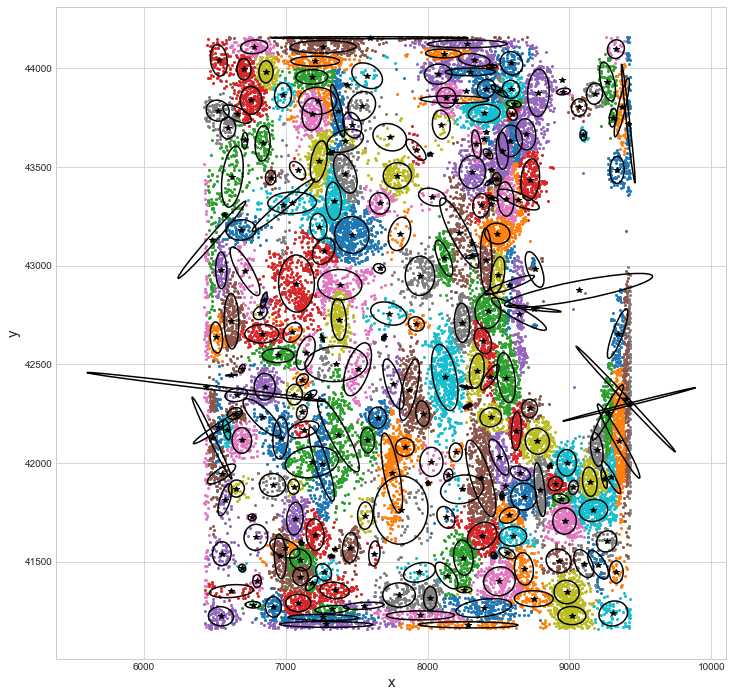

In [17]:
plot_clusters(df_spatial_subset, clusters_info, color_cluster=True, fig_size=(12, 12))

### Filter extreme cells

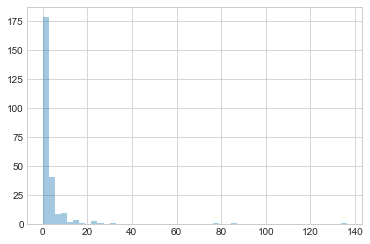

In [18]:
stds = clusters_info[['StdX', 'StdY']].values 

eps = 1e-5
size = clusters_info['Size'] = stds.max(axis=1) / (stds.min(axis=1) + eps)
sns.distplot(size[size < 5000], kde=False);

In [19]:
resizable_clusters = clusters_info.loc[(clusters_info.Size < 6) & (clusters_info.Size >= 0.7)]

resizable_spatial = []
for i in resizable_clusters.index:
    resizable_spatial.append(df_spatial_subset.loc[df_spatial_subset.Class == i])
resizable_spatial = pd.concat(resizable_spatial, axis=0)

df_spatial_subset.shape, resizable_spatial.shape

((26097, 5), (22422, 5))

-2.6532482861769595


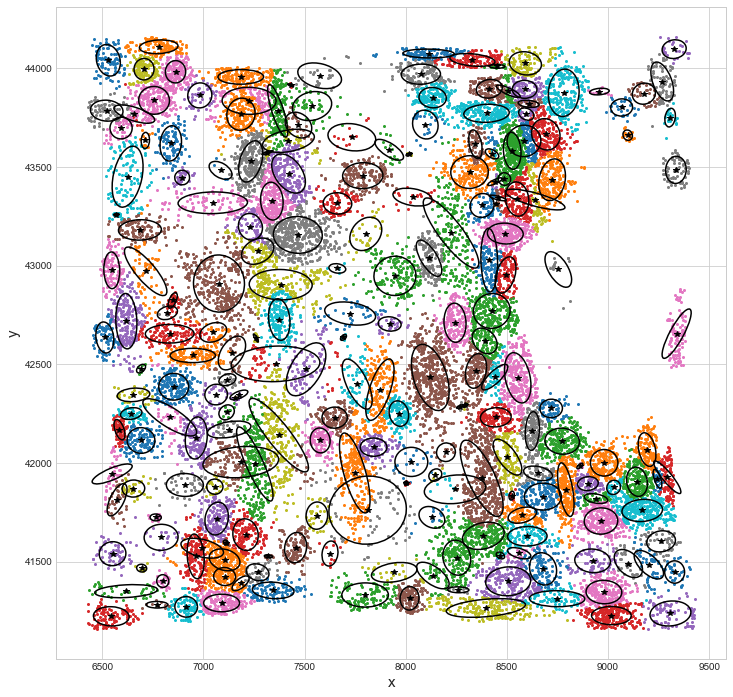

In [20]:
plot_clusters(resizable_spatial, resizable_clusters, color_cluster=True, fig_size=(12, 12))